# COMP3222 Machine Learning Technologies Coursework
## John Holman (jh11g20@soton.ac.uk)

### First we need to import the data

In [142]:
import pandas as pd
import numpy as np
import tensorflow as tf
import nltk
from lingua import Language, LanguageDetectorBuilder

In [143]:
file_path = 'Data/mediaeval-2015-trainingset.txt'
df = pd.read_csv(file_path, sep='\t')
df.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


Now the data is imported we can analyse what to do with it.

Firstly we need to identify what the problem is and what the solution is. 

The spec outlines that this particular problem involves determining whether these tweets were fake or real. In the training data, this is provided. 

We can also see how many entries we have been given to work with. 

In [433]:
print("Number of columns {}".format(len(df.columns)))
print("Number of rows {}".format(len(df)))

Number of columns 8
Number of rows 14277


So we are given 14,277 data entries in the training dataset. We have 7 different features currently listed. 

We should also potentially check our features to see what kind of format each one has and whether they are consistent. 

In [145]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     14277 non-null  int64 
 1   tweetText   14277 non-null  object
 2   userId      14277 non-null  int64 
 3   imageId(s)  14277 non-null  object
 4   username    14277 non-null  object
 5   timestamp   14277 non-null  object
 6   label       14277 non-null  object
dtypes: int64(2), object(5)
memory usage: 780.9+ KB


This shows that our tweetID and userID are int64 however the rest of the values are just object meaning they could be anything. 

That being said having no null values is quite nice

We should check to see what different values are available for the label

In [146]:
df["label"].value_counts()

label
fake     6742
real     4921
humor    2614
Name: count, dtype: int64

So we can see that the labels inlcude not only 'real' and 'fake' but also another label for 'humor'. Given that a fake post and a humourous post will likely both not be correct, it seems to detemine a real post, a model could treat humourous posts as if they were fake, but to determine a fake post, the model needs to be able determine the difference between humor and fake. 

### We can see now clearly that this is a classification problem. And that it is supervised

There 3 different options a data entry could be classified as, 'real', 'fake', and 'humor' however the spec does actually specify that for the purposes of this model, 'humor' can be considered the same as 'fake' as we only need to make a binary classifier. 

In [147]:
df["userId"].value_counts()

userId
139189262     16
834560797     10
357078809      9
89221442       8
2623669827     8
              ..
24325804       1
872756892      1
43403432       1
38661399       1
25086784       1
Name: count, Length: 13498, dtype: int64

In [148]:
df["username"].value_counts()

username
SAGandAFTRA        16
ShadyBoyfriend     10
Bin_HAMADA          9
IzisFilipaldi       8
IIIIsabelllaa       8
                   ..
martinoborghesi     1
my_momentintime     1
TephaCabascango     1
irishpaintings      1
johnszim            1
Name: count, Length: 13498, dtype: int64

Doing this enables us to see that there are plenty of different users. 
However, you can notice some users post a lot more than others, this could be factored in to the model. 

It seems that there are no missing values. And it seems for the most part, initially all of our data entries are useful. 
Our data entries consist of one time entry (could be considered numerical especially if converted to the UNIX epoch count), which will be very useful to an algorithm, 3 text entries (tweet text, imageID, username) plus two numerical values of tweetID and userID, however these features are not typical numbers and exist much more like a categorical feature except with no limit to which categories are available. 

Humor is listed a possible label, and in the paper published for the given task, they have removed the entries with humor and focused plainly on simply real or fake. It might perhaps be useful to still include humor so an options would be to have two training datasets, one with humor included, and one without. The one with humor included most likely needs to have humor replaced with fake otherwise the algorithm would potentially predict humor for the test set. 

In [149]:
noHumorSet = df[df["label"] != 'humor'].reset_index(drop=True)
noHumorSet.info()
noHumorSet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11663 entries, 0 to 11662
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   tweetId     11663 non-null  int64 
 1   tweetText   11663 non-null  object
 2   userId      11663 non-null  int64 
 3   imageId(s)  11663 non-null  object
 4   username    11663 non-null  object
 5   timestamp   11663 non-null  object
 6   label       11663 non-null  object
dtypes: int64(2), object(5)
memory usage: 637.9+ KB


,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake


Another thing that needs addressing is a lot of, or arguably all of the data is in a text based or categorical form. We need to vectorise the text data and process it. 

Firstly, it would be a good idea to change the timestamp to a numerical format that can be read. There are a few formats that are likely to be useful. 

Firstly we need to see what range of dates the data covers. 

In [150]:
dates = pd.DataFrame()
dates["year"] = df["timestamp"]
dates.head()

,year
0,Mon Oct 29 22:34:01 +0000 2012
1,Mon Oct 29 19:11:23 +0000 2012
2,Mon Oct 29 18:11:08 +0000 2012
3,Mon Oct 29 19:15:33 +0000 2012
4,Mon Oct 29 20:46:02 +0000 2012


In [151]:
dates["day"] = dates["year"].str.split().str[0]
dates["year"] = dates["year"].str.split().str[-1]

dates.head()

,year,day
0,2012,Mon
1,2012,Mon
2,2012,Mon
3,2012,Mon
4,2012,Mon


In [152]:
dates["day"].value_counts()

day
Tue    4371
Mon    3712
Thu    1985
Fri    1380
Sun    1086
Sat     894
Wed     849
Name: count, dtype: int64

In [153]:
dates["year"].value_counts()

year
2012    12318
2014     1413
2013      546
Name: count, dtype: int64

With this, we can see that the data only covers the years 2012,2013, and 2014. and covers all days of the week. This means that the overall year and or overall time value probably doesn't matter as much as our training data only covers 3 years and only 2012 has a sizeable amount of data from it. Therefore figuring out what time of year the tweet was from as well as what time of day, most likely will yield better results. 

To work out a good value for time of day and the time of year, a good option is to calculate sine and cosine values for them, this will provide data to essentially let the model know that for example day 364 is very close to day 1, or 23:55 is close to 00:10. 

Firstly these date and time values should be converted into a unix numerical timestamp, as to reduce over-dimensionality, we only want the overall time of year and overall time of day, rather than having values also for minutes and seconds, they should be factored in (therefore 4:30 would be treated as 4.5 essentially)

In [154]:
format_string = "%a %b %d %H:%M:%S %z %Y"
df = df.assign(datetime=pd.to_datetime(df['timestamp'], format=format_string))
df.head()

ValueError: time data "Tue Mar 11 23: 59: 22 +0000 2014" doesn't match format "%a %b %d %H:%M:%S %z %Y", at position 14254. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

This has a problem, identified that the input string is not always of the right format.
ValueError: time data "Tue Mar 11 23: 59: 22 +0000 2014" doesn't match format "%a %b %d %H:%M:%S %z %Y", at position 14254

Because of this I will have to retry but accounting for this

In [155]:
format_string = "%a %b %d %H:%M:%S %z %Y"
secondary_string = "%a %b %d %H: %M: %S %z %Y"

df["dateTime"] = pd.to_datetime(df['timestamp'], format=format_string, errors='coerce')
df["dateTime"] = df["dateTime"].fillna(pd.to_datetime(df['timestamp'], format=secondary_string, errors='coerce'))

df.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,dateTime
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,Mon Oct 29 22:34:01 +0000 2012,fake,2012-10-29 22:34:01+00:00
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,Mon Oct 29 19:11:23 +0000 2012,fake,2012-10-29 19:11:23+00:00
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,Mon Oct 29 18:11:08 +0000 2012,fake,2012-10-29 18:11:08+00:00
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,Mon Oct 29 19:15:33 +0000 2012,fake,2012-10-29 19:15:33+00:00
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,Mon Oct 29 20:46:02 +0000 2012,fake,2012-10-29 20:46:02+00:00


In [156]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweetId     14277 non-null  int64              
 1   tweetText   14277 non-null  object             
 2   userId      14277 non-null  int64              
 3   imageId(s)  14277 non-null  object             
 4   username    14277 non-null  object             
 5   timestamp   14277 non-null  object             
 6   label       14277 non-null  object             
 7   dateTime    14277 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(5)
memory usage: 892.4+ KB


Now that we have the dateTime and it has been checked to definitely have all of the values
we can drop the timestamp column

In [157]:
new = df.drop(columns=['timestamp'])
new.head()

,tweetId,tweetText,userId,imageId(s),username,label,dateTime
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,fake,2012-10-29 22:34:01+00:00
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,fake,2012-10-29 19:11:23+00:00
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,fake,2012-10-29 18:11:08+00:00
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,2012-10-29 19:15:33+00:00
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,fake,2012-10-29 20:46:02+00:00


In [158]:
new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   tweetId     14277 non-null  int64              
 1   tweetText   14277 non-null  object             
 2   userId      14277 non-null  int64              
 3   imageId(s)  14277 non-null  object             
 4   username    14277 non-null  object             
 5   label       14277 non-null  object             
 6   dateTime    14277 non-null  datetime64[ns, UTC]
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 780.9+ KB


So now we have converted the date and time into a dateTime object. This however still cannot be processed in a machine learning model, we need to convert it to numbers, however the important information we need is what time of year it was, and what time of day it was, and possibly what time of week it was (given that the day of the week was specified and rightly so, as tweet habits may change on a weekend or otherwise). 

We can turn the dateTime value into seconds. 

In [159]:
new["secondsTime"] = new["dateTime"].map(pd.Timestamp.timestamp)

new.head()

,tweetId,tweetText,userId,imageId(s),username,label,dateTime,secondsTime
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,fake,2012-10-29 22:34:01+00:00,1.351550e+09
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,fake,2012-10-29 19:11:23+00:00,1.351538e+09
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,fake,2012-10-29 18:11:08+00:00,1.351534e+09
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,2012-10-29 19:15:33+00:00,1.351538e+09
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,fake,2012-10-29 20:46:02+00:00,1.351544e+09


In [160]:
day = 24*60*60
week = 7*day
year = (365.2422)*day

new["Day sin"] = np.sin(new["secondsTime"] * (2 * np.pi / day))
new["Day cos"] = np.cos(new["secondsTime"] * (2 * np.pi / day))
new["Week sin"] = np.sin(new["secondsTime"] * (2 * np.pi / week))
new["Week cos"] = np.cos(new["secondsTime"] * (2 * np.pi / week))
new["Year sin"] = np.sin(new["secondsTime"] * (2 * np.pi / year))
new["Year cos"] = np.cos(new["secondsTime"] * (2 * np.pi / year))

new.head()

,tweetId,tweetText,userId,imageId(s),username,label,dateTime,secondsTime,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,fake,2012-10-29 22:34:01+00:00,1.351550e+09,-0.366434,0.930444,-0.961607,-0.274429,-0.879463,0.475967
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,fake,2012-10-29 19:11:23+00:00,1.351538e+09,-0.951885,0.306457,-0.919377,-0.393378,-0.880612,0.473837
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,fake,2012-10-29 18:11:08+00:00,1.351534e+09,-0.998820,0.048559,-0.903958,-0.427621,-0.880953,0.473203
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,2012-10-29 19:15:33+00:00,1.351538e+09,-0.946156,0.323711,-0.920395,-0.390989,-0.880589,0.473881
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,fake,2012-10-29 20:46:02+00:00,1.351544e+09,-0.748859,0.662729,-0.940972,-0.338484,-0.880076,0.474833


In [161]:
newTime = new.drop(columns=['dateTime','secondsTime'])
newTime.head()

,tweetId,tweetText,userId,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
0,263046056240115712,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,-0.879463,0.475967
1,262995061304852481,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,-0.880612,0.473837
2,262979898002534400,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,-0.880953,0.473203
3,262996108400271360,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,-0.880589,0.473881
4,263018881839411200,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,-0.880076,0.474833


In [162]:
newTime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14277 entries, 0 to 14276
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   tweetId     14277 non-null  int64  
 1   tweetText   14277 non-null  object 
 2   userId      14277 non-null  int64  
 3   imageId(s)  14277 non-null  object 
 4   username    14277 non-null  object 
 5   label       14277 non-null  object 
 6   Day sin     14277 non-null  float64
 7   Day cos     14277 non-null  float64
 8   Week sin    14277 non-null  float64
 9   Week cos    14277 non-null  float64
 10  Year sin    14277 non-null  float64
 11  Year cos    14277 non-null  float64
dtypes: float64(6), int64(2), object(4)
memory usage: 1.3+ MB


So now we have the date and time formatted into day sin and cos and year sin and cos which gives the model easy, numerical values to determine what time of day and what time of year the tweet was sent out. There will be slight overlap between the day and year given that it was converted from seconds so a different time of day on the same day will mean that the year value will be slightly different but that is fine. 

We can do some early dimensionality reduction such as removing some unimportant columns. One such column is the tweetID. This simply contains the timestamp (which we already have) and things like the worker number. We cannot go and use any API to retrieve more data about the tweet or the user so it is safe to simply delete the tweetID from the dataSet. 

In [163]:
noID = newTime.drop(columns=['tweetId'])
noID.head()

,tweetText,userId,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
0,¿Se acuerdan de la película: “El día después d...,21226711,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,-0.879463,0.475967
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,192378571,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,-0.880612,0.473837
2,"Buena la foto del Huracán Sandy, me recuerda a...",132303095,sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,-0.880953,0.473203
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,241995902,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,-0.880589,0.473881
4,My fave place in the world #nyc #hurricane #sa...,250315890,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,-0.880076,0.474833


For this coursework, we have been instructed to not retrieve any task-specific data. This would mean that we cannot use the twitter API to extract any further data about the tweet or the user, and thus the userID most likely is irrelevant. If we were allowed to gather more information however, I would likely want to gather information such as the age of the user account, relevant statistics on their engagement, like average likes, retweets, followers, post frequency. As well as ideally information about tweets such as likes and retweets from the tweet ID. However given the restrictions, being unable to do that means that the userID is for the most part, irrelevant. 

In [164]:
noID = noID.drop(columns=['userId'])
noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,Year sin,Year cos
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,-0.879463,0.475967
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,-0.880612,0.473837
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,-0.880953,0.473203
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,-0.880589,0.473881
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,-0.880076,0.474833


We also should look at the statistics for the day, week, and year values to see if they have a good spread of data

array([[<Axes: title={'center': 'Day sin'}>,
        <Axes: title={'center': 'Day cos'}>],
       [<Axes: title={'center': 'Week sin'}>,
        <Axes: title={'center': 'Week cos'}>],
       [<Axes: title={'center': 'Year sin'}>,
        <Axes: title={'center': 'Year cos'}>]], dtype=object)

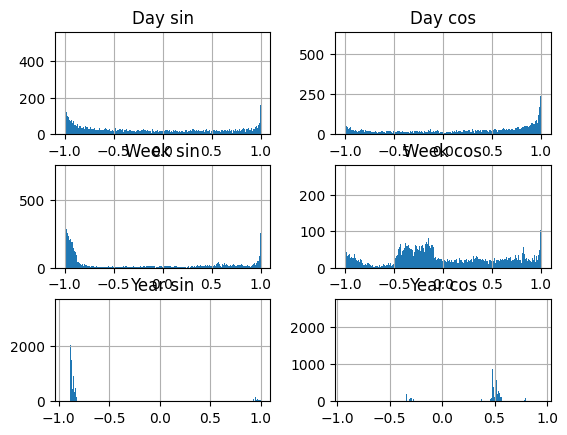

In [165]:
noID.hist(bins=500)

In [166]:
monthList = df["dateTime"].dt.month

monthList.head()

0    10
1    10
2    10
3    10
4    10
Name: dateTime, dtype: int32

<Axes: >

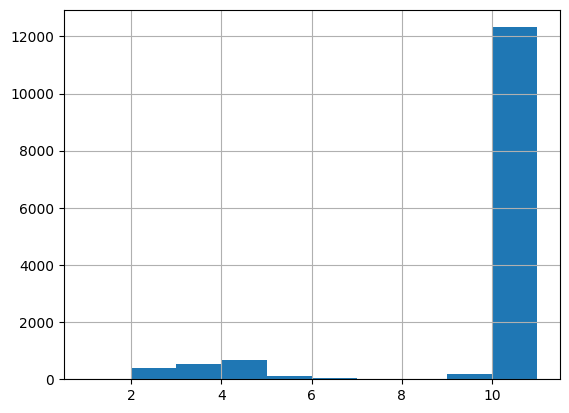

In [167]:
monthList.hist()

Because of the nature of tweets typically following a natural disaster, the data for what time of year ends up being heavily skewed towards certain months. Alternatively you can see that time of day and time of week are much more spread out. Including time of year will likely skew the machine learning algorithm with bias so we should remove it. 

In [168]:
noID = noID.drop(columns=['Year sin','Year cos'])

In [169]:
noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484


Next we need to focus on what data is important, and also how we can extract the important parts of the given data. We need everything to be in numerical format so we are going to need to use some kind of natural language processing. 

Before we do that, we still need to clean the data more to make sure that everything is in the correct format and that all the text is parsed correctly. 

Only then can we begin the natural language processing to extract key features from the text. 

To determine if there is any problems, I decide to get a language detection library, and analyse each language to determine what it is. The library (lingua) was chosen specifically because of its very high accuracy particularly with short bits of text

In [170]:
detector = LanguageDetectorBuilder.from_all_languages().build()
def determineLanguage(tweetText):
    confidenceValues = detector.compute_language_confidence_values(tweetText)
    result = confidenceValues[0]
    return result.language.name, result.value

test = noID.head()


test[['Tweet language','Confidence']] = test["tweetText"].apply(lambda x: pd.Series(determineLanguage(x)))

test.head()

C:\Users\John\AppData\Local\Temp\ipykernel_10080\385839098.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Tweet language','Confidence']] = test["tweetText"].apply(lambda x: pd.Series(determineLanguage(x)))
C:\Users\John\AppData\Local\Temp\ipykernel_10080\385839098.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Tweet language','Confidence']] = test["tweetText"].apply(lambda x: pd.Series(determineLanguage(x)))


,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,Tweet language,Confidence
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,SPANISH,0.996955
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,SPANISH,0.349072
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,SPANISH,0.906542
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,YORUBA,0.182779
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,ENGLISH,0.344522


Looking at this, a test for language detection shows that there are problems. This might be influenced by the hashtags and user mentions so I will create a new feature of only the body of the tweet text. We need to remove @ mentions, hashtags, and hyperlinks

# Old code below, up until the next warning like this. You may run it if you wish but there isn't much point. It is just there to show the process and so you can see the parsing issues mentioned for yourself

In [35]:
import re
def getTweetBody(text):
    #remove user mentions (words starting with '@')
    text = re.sub(r'@\w+', '', text)

    #remove hashtags (words starting with '#')
    text = re.sub(r'#\w+', '', text)

    #remove hyperlinks
    text = re.sub(r'https?://\S+', '', text)

    return text

In [36]:
noID["tweetTextBody"] = noID["tweetText"].apply(getTweetBody)

noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽


In [34]:
test = noID.head()


test[['Tweet language','Confidence']] = test["tweetTextBody"].apply(lambda x: pd.Series(determineLanguage(x)))

test.head()

C:\Users\John\AppData\Local\Temp\ipykernel_22088\3030816930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Tweet language','Confidence']] = test["tweetTextBody"].apply(lambda x: pd.Series(determineLanguage(x)))
C:\Users\John\AppData\Local\Temp\ipykernel_22088\3030816930.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test[['Tweet language','Confidence']] = test["tweetTextBody"].apply(lambda x: pd.Series(determineLanguage(x)))


,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952


In [35]:
badString = "FBI ΰΉ€ΰΈ??ΰΈΆΰΈ ΰΈ²ΰΈ??ΰΈ΅ΰΈ·ΰΈ­ΰΈ£ΰΈ°ΰΉ€ΰΈ??ΰΈ΄ΰΈ”ΰΈ΅ΰΈ²ΰΈ£ΰΈ²ΰΈ??ΰΈ­ΰΈ™ΰΈ??ΰΈ­ΰΈΰΈ•ΰΈ±ΰΈ™ ΰΈ—ΰΈµΰΉ??ΰΈ??ΰΈ³ΰΈ¥ΰΈ±ΰΈ‡ΰΈ«ΰΈ¥ΰΈ??ΰΈ«ΰΈ™ΰΈµ ΰΈ??ΰΈ·ΰΉ??ΰΈ­ Dzhokhar A. Tsarnaev"

confidenceValues = detector.compute_language_confidence_values(badString)
result = confidenceValues[0]
print(confidenceValues)

[ConfidenceValue(language=Language.GREEK, value=1.0), ConfidenceValue(language=Language.AFRIKAANS, value=0.0), ConfidenceValue(language=Language.ALBANIAN, value=0.0), ConfidenceValue(language=Language.ARABIC, value=0.0), ConfidenceValue(language=Language.ARMENIAN, value=0.0), ConfidenceValue(language=Language.AZERBAIJANI, value=0.0), ConfidenceValue(language=Language.BASQUE, value=0.0), ConfidenceValue(language=Language.BELARUSIAN, value=0.0), ConfidenceValue(language=Language.BENGALI, value=0.0), ConfidenceValue(language=Language.BOKMAL, value=0.0), ConfidenceValue(language=Language.BOSNIAN, value=0.0), ConfidenceValue(language=Language.BULGARIAN, value=0.0), ConfidenceValue(language=Language.CATALAN, value=0.0), ConfidenceValue(language=Language.CHINESE, value=0.0), ConfidenceValue(language=Language.CROATIAN, value=0.0), ConfidenceValue(language=Language.CZECH, value=0.0), ConfidenceValue(language=Language.DANISH, value=0.0), ConfidenceValue(language=Language.DUTCH, value=0.0), Confi

In [36]:
noID[['Tweet language','Confidence']] = noID["tweetTextBody"].apply(lambda x: pd.Series(determineLanguage(x)))

noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952


In [37]:
noID.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish http: \/\/t...,ENGLISH,0.183488
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.789541
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this? http: \/\/t.co\/4Bml62OD15,ENGLISH,0.101074
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,TSONGA,0.253322
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.574300


In [38]:
noID['Tweet language'].value_counts()

Tweet language
ENGLISH        9659
SPANISH        1347
AFRIKAANS       915
FRENCH          277
WELSH           202
               ... 
HEBREW            1
LATVIAN           1
AZERBAIJANI       1
PERSIAN           1
HINDI             1
Name: count, Length: 61, dtype: int64

<Axes: xlabel='Tweet language'>

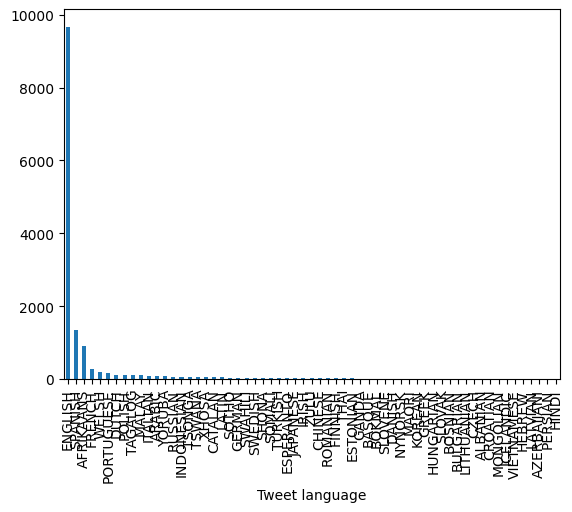

In [39]:
noID['Tweet language'].value_counts().plot(kind='bar')

<Axes: >

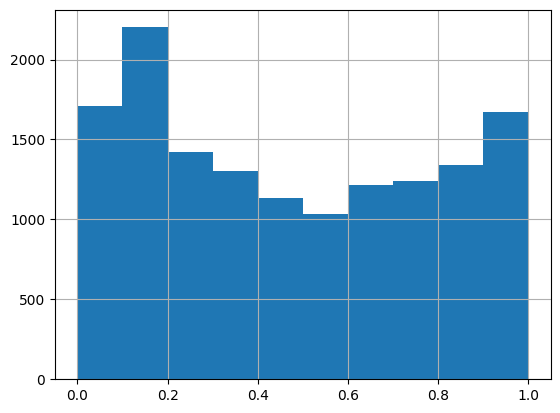

In [40]:
noID['Confidence'].hist()

So from this we can see that the majority of the tweets are determined to be in English with about 10 other languages coming up somewhat commonly. However we can see that the confience scores are not particularly great. Part of this is because confidence scores go up the more text is available. 

We might want to throw out entries that have low confidence scores despite having relatively long text. 

In [41]:
noID["Length"] = noID["tweetTextBody"].apply(lambda x: pd.Series(len(x)))
noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33


In [42]:
noID["Confidence/Length"] = noID["Confidence"] / noID["Length"]
noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302


In [43]:
noID.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish http: \/\/t...,ENGLISH,0.183488,61,0.003008
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.789541,124,0.006367
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this? http: \/\/t.co\/4Bml62OD15,ENGLISH,0.101074,49,0.002063
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,TSONGA,0.253322,81,0.003127
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.574300,79,0.007270


# End of old code

We can see that some of the hyperlinks are still there, some of the hyperlinks are formatted wrong and have a space after the http and some have '\/' instead of '/'. Presumably because of parsing issues as the '\' symbol can be used to denote a literal character where normally the thing after it might be considered an operator of some kind

In [203]:
def getTweetBodyFixed(text):
    #remove newlines
    text = re.sub(r'\\n',' ',text)
    
    #remove email addresses
    text = re.sub(r'\S+@\S+\.[a-zA-Z]{2,}','',text)

    #remove user mentions (words starting with '@')
    text = re.sub(r'@\s+','@',text)
    text = re.sub(r'@\w+', '', text)

    #replace incorrectly formatted '\/' with the correct '/'
    text = re.sub(r'\\/', '/', text)

    #remove hyperlinks
    text = re.sub(r'https?:\s?//\S+', '', text)

    #remove hashtags (words starting with '#')
    text = re.sub(r'#\s+','#',text)
    text = re.sub(r'#\w+', '', text)

    

    return text

In [204]:
noID["tweetTextBody"] = noID["tweetText"].apply(getTweetBodyFixed)

noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk


In [205]:
noID[['Tweet language','Confidence']] = noID["tweetTextBody"].apply(lambda x: pd.Series(determineLanguage(x)))

noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk


In [206]:
noID.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,0.333921,35,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.775199,98,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,0.197877,23,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,0.293495,55,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.775301,53,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg


In [207]:
noID['Tweet language'].value_counts()

Tweet language
ENGLISH        9652
SPANISH        1352
AFRIKAANS       933
FRENCH          280
WELSH           198
               ... 
HEBREW            1
LATVIAN           1
AZERBAIJANI       1
PERSIAN           1
HINDI             1
Name: count, Length: 61, dtype: int64

<Axes: >

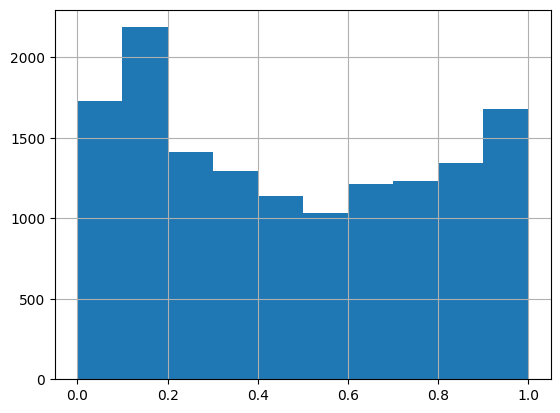

In [208]:
noID['Confidence'].hist()

In [209]:
noID["Length"] = noID["tweetTextBody"].apply(lambda x: pd.Series(len(x)))
noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk


In [210]:
noID["Confidence/Length"] = noID["Confidence"] / noID["Length"]
noID.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,0.333921,35,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.775199,98,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,0.197877,23,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,0.293495,55,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.775301,53,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg


now we can see a confidence per length value

<Axes: >

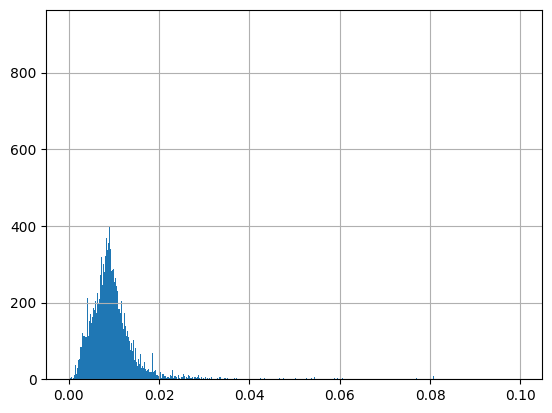

In [211]:
noID['Confidence/Length'].hist(bins=500)

In [212]:
noID['Confidence/Length'].describe()

count    14277.000000
mean         0.009277
std          0.006805
min          0.000000
25%          0.005989
50%          0.008670
75%          0.011181
max          0.099809
Name: Confidence/Length, dtype: float64

One possible change to revisit is changing the different languages to simply "english or non-english". This will be revisited when testing the algorithm effectiveness. 

<Axes: xlabel='Tweet language'>

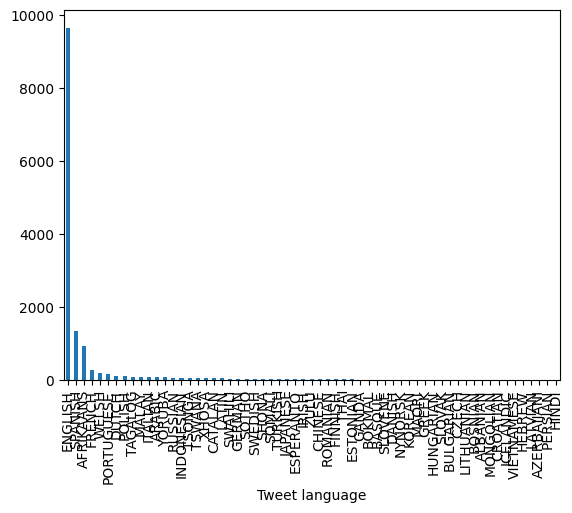

In [213]:
noID['Tweet language'].value_counts().plot(kind='bar')

In [214]:
noID['Length'].describe()

count    14277.000000
mean        53.518877
std         90.984608
min          1.000000
25%         27.000000
50%         49.000000
75%         75.000000
max       5952.000000
Name: Length, dtype: float64

This is good, however there is one element that has a length of 0 and thus doesn't show up when you get a description of confidence/length

Additionally there are many languages which have very little data on them. Because the vast majority of data is English. I think it would be best to simply categorise them as either English or not english. There is just shy of 10,000 english posts and therefore probably about 4500-5000 non-english posts

In [215]:
noID['isEnglish'] = (noID['Tweet language'] == "ENGLISH").astype(int)
noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk


In [216]:
noID.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,0.333921,35,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.775199,98,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,0.197877,23,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,0.293495,55,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.775301,53,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg


Now we move properly onto the natural language processing side of things. We need to extract useful information from the tweet text, the imageID and the username. We have the main body of the tweet, but it would be good to also get the hashtags, plus any mentions. 
We also need to make sure not to get any email addresses that might be included. 


In [217]:
def getCleanedTweetText(text):
    #remove newlines
    text = re.sub(r'\\n',' ',text)
    
    #remove email addresses
    text = re.sub(r'\S+@\S+\.[a-zA-Z]{2,}','',text)
    
    #remove user mentions (words starting with '@')
    text = re.sub(r'@\s+','@',text)

    #remove hashtags (words starting with '#')
    text = re.sub(r'#\s+','#',text)

    #replace incorrectly formatted '\/' with the correct '/'
    text = re.sub(r'\\/', '/', text)

    return text

def getMentions(text):
    text = re.sub(r'https?:\s?//\S+', '', text)
    text = re.sub(r'@\s+','@',text)
    text = re.sub(r'\S+@\S+\.[a-zA-Z]{2,}','',text)
    mentions = re.findall(r'@\w+', text)
                          
    result = ','.join(mentions)
    return result

def getHashtags(text):
    text = re.sub(r'#\s+','#',text)
    tags = re.findall(r'#\w+', text)
    result = ','.join(tags)
    return result

def getLinks(text):
    text = re.sub(r'\\/', '/', text)
    links = re.findall(r'https?:\s?//\S+', text)
    result = ','.join(links)
    return result

In [218]:
noID['cleanedText'] = noID['tweetText'].apply(getCleanedTweetText)

noID['Mentions'] = noID['cleanedText'].apply(getMentions)
noID['Hashtags'] = noID['cleanedText'].apply(getHashtags)
noID['Links'] = noID['cleanedText'].apply(getLinks)

noID.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk


In [219]:
noID.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,0.333921,35,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.775199,98,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,0.197877,23,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,0.293495,55,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.775301,53,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg


In [220]:
noID[noID['Confidence/Length'].isna()]

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links


In [221]:
from deep_translator import GoogleTranslator

In [222]:
GoogleTranslator().get_supported_languages()

['afrikaans',
 'albanian',
 'amharic',
 'arabic',
 'armenian',
 'assamese',
 'aymara',
 'azerbaijani',
 'bambara',
 'basque',
 'belarusian',
 'bengali',
 'bhojpuri',
 'bosnian',
 'bulgarian',
 'catalan',
 'cebuano',
 'chichewa',
 'chinese (simplified)',
 'chinese (traditional)',
 'corsican',
 'croatian',
 'czech',
 'danish',
 'dhivehi',
 'dogri',
 'dutch',
 'english',
 'esperanto',
 'estonian',
 'ewe',
 'filipino',
 'finnish',
 'french',
 'frisian',
 'galician',
 'georgian',
 'german',
 'greek',
 'guarani',
 'gujarati',
 'haitian creole',
 'hausa',
 'hawaiian',
 'hebrew',
 'hindi',
 'hmong',
 'hungarian',
 'icelandic',
 'igbo',
 'ilocano',
 'indonesian',
 'irish',
 'italian',
 'japanese',
 'javanese',
 'kannada',
 'kazakh',
 'khmer',
 'kinyarwanda',
 'konkani',
 'korean',
 'krio',
 'kurdish (kurmanji)',
 'kurdish (sorani)',
 'kyrgyz',
 'lao',
 'latin',
 'latvian',
 'lingala',
 'lithuanian',
 'luganda',
 'luxembourgish',
 'macedonian',
 'maithili',
 'malagasy',
 'malay',
 'malayalam',
 

In [223]:
testing = noID.tail()

testing.head()



,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,0.333921,35,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.775199,98,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,0.197877,23,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,0.293495,55,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.775301,53,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg


In [224]:
testing['translatedTweetBody'] = testing.apply(lambda row: row['tweetTextBody'] if row['isEnglish'] else GoogleTranslator(source=row['Tweet language'].lower(), target='english').translate(row['tweetTextBody']), axis=1)
testing.head()

C:\Users\John\AppData\Local\Temp\ipykernel_10080\2490999086.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing['translatedTweetBody'] = testing.apply(lambda row: row['tweetTextBody'] if row['isEnglish'] else GoogleTranslator(source=row['Tweet language'].lower(), target='english').translate(row['tweetTextBody']), axis=1)


,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody
14272,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,0.333921,35,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA,*slaps TweetDeck with the PigFish
14273,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,0.775199,98,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs,New Species of Fish found in Brazil or just Re...
14274,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,0.197877,23,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15,What do we call this?
14275,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,0.293495,55,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef,Pigfish? And after the dogfish there is the pi...
14276,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,0.775301,53,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg,For those who can't decide between fish or mea...


In [69]:
noID['translatedTweetBody'] = noID.apply(lambda row: row['tweetTextBody'] if row['isEnglish'] else GoogleTranslator(source=row['Tweet language'].lower(), target='english').translate(row['tweetTextBody']), axis=1)
noID.head()

LanguageNotSupportedException: nynorsk --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 'icelandic': 'is', 'igbo': 'ig', 'ilocano': 'ilo', 'indonesian': 'id', 'irish': 'ga', 'italian': 'it', 'japanese': 'ja', 'javanese': 'jw', 'kannada': 'kn', 'kazakh': 'kk', 'khmer': 'km', 'kinyarwanda': 'rw', 'konkani': 'gom', 'korean': 'ko', 'krio': 'kri', 'kurdish (kurmanji)': 'ku', 'kurdish (sorani)': 'ckb', 'kyrgyz': 'ky', 'lao': 'lo', 'latin': 'la', 'latvian': 'lv', 'lingala': 'ln', 'lithuanian': 'lt', 'luganda': 'lg', 'luxembourgish': 'lb', 'macedonian': 'mk', 'maithili': 'mai', 'malagasy': 'mg', 'malay': 'ms', 'malayalam': 'ml', 'maltese': 'mt', 'maori': 'mi', 'marathi': 'mr', 'meiteilon (manipuri)': 'mni-Mtei', 'mizo': 'lus', 'mongolian': 'mn', 'myanmar': 'my', 'nepali': 'ne', 'norwegian': 'no', 'odia (oriya)': 'or', 'oromo': 'om', 'pashto': 'ps', 'persian': 'fa', 'polish': 'pl', 'portuguese': 'pt', 'punjabi': 'pa', 'quechua': 'qu', 'romanian': 'ro', 'russian': 'ru', 'samoan': 'sm', 'sanskrit': 'sa', 'scots gaelic': 'gd', 'sepedi': 'nso', 'serbian': 'sr', 'sesotho': 'st', 'shona': 'sn', 'sindhi': 'sd', 'sinhala': 'si', 'slovak': 'sk', 'slovenian': 'sl', 'somali': 'so', 'spanish': 'es', 'sundanese': 'su', 'swahili': 'sw', 'swedish': 'sv', 'tajik': 'tg', 'tamil': 'ta', 'tatar': 'tt', 'telugu': 'te', 'thai': 'th', 'tigrinya': 'ti', 'tsonga': 'ts', 'turkish': 'tr', 'turkmen': 'tk', 'twi': 'ak', 'ukrainian': 'uk', 'urdu': 'ur', 'uyghur': 'ug', 'uzbek': 'uz', 'vietnamese': 'vi', 'welsh': 'cy', 'xhosa': 'xh', 'yiddish': 'yi', 'yoruba': 'yo', 'zulu': 'zu'}

We can see there is a problem in translation, this is because the identifier identified nynorsk which is a less common written form of norwegian. Because it is different to standard norwegian, it is better to remove that entry from the table. 

In [70]:
noNynorsk = noID[noID['Tweet language'] != 'NYNORSK']
noNynorsk.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14266 entries, 0 to 14276
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweetText          14266 non-null  object 
 1   imageId(s)         14266 non-null  object 
 2   username           14266 non-null  object 
 3   label              14266 non-null  object 
 4   Day sin            14266 non-null  float64
 5   Day cos            14266 non-null  float64
 6   Week sin           14266 non-null  float64
 7   Week cos           14266 non-null  float64
 8   tweetTextBody      14266 non-null  object 
 9   Tweet language     14266 non-null  object 
 10  Confidence         14266 non-null  float64
 11  Length             14266 non-null  int64  
 12  Confidence/Length  14265 non-null  float64
 13  isEnglish          14266 non-null  int32  
 14  Mentions           14266 non-null  object 
 15  Hashtags           14266 non-null  object 
 16  Links              14266 no

In [71]:
noNynorsk['translatedTweetBody'] = noNynorsk.apply(lambda row: row['tweetTextBody'] if row['isEnglish'] else GoogleTranslator(source=row['Tweet language'].lower(), target='english').translate(row['tweetTextBody']), axis=1)
noNynorsk.head()

LanguageNotSupportedException: tagalog --> No support for the provided language.
Please select on of the supported languages:
{'afrikaans': 'af', 'albanian': 'sq', 'amharic': 'am', 'arabic': 'ar', 'armenian': 'hy', 'assamese': 'as', 'aymara': 'ay', 'azerbaijani': 'az', 'bambara': 'bm', 'basque': 'eu', 'belarusian': 'be', 'bengali': 'bn', 'bhojpuri': 'bho', 'bosnian': 'bs', 'bulgarian': 'bg', 'catalan': 'ca', 'cebuano': 'ceb', 'chichewa': 'ny', 'chinese (simplified)': 'zh-CN', 'chinese (traditional)': 'zh-TW', 'corsican': 'co', 'croatian': 'hr', 'czech': 'cs', 'danish': 'da', 'dhivehi': 'dv', 'dogri': 'doi', 'dutch': 'nl', 'english': 'en', 'esperanto': 'eo', 'estonian': 'et', 'ewe': 'ee', 'filipino': 'tl', 'finnish': 'fi', 'french': 'fr', 'frisian': 'fy', 'galician': 'gl', 'georgian': 'ka', 'german': 'de', 'greek': 'el', 'guarani': 'gn', 'gujarati': 'gu', 'haitian creole': 'ht', 'hausa': 'ha', 'hawaiian': 'haw', 'hebrew': 'iw', 'hindi': 'hi', 'hmong': 'hmn', 'hungarian': 'hu', 'icelandic': 'is', 'igbo': 'ig', 'ilocano': 'ilo', 'indonesian': 'id', 'irish': 'ga', 'italian': 'it', 'japanese': 'ja', 'javanese': 'jw', 'kannada': 'kn', 'kazakh': 'kk', 'khmer': 'km', 'kinyarwanda': 'rw', 'konkani': 'gom', 'korean': 'ko', 'krio': 'kri', 'kurdish (kurmanji)': 'ku', 'kurdish (sorani)': 'ckb', 'kyrgyz': 'ky', 'lao': 'lo', 'latin': 'la', 'latvian': 'lv', 'lingala': 'ln', 'lithuanian': 'lt', 'luganda': 'lg', 'luxembourgish': 'lb', 'macedonian': 'mk', 'maithili': 'mai', 'malagasy': 'mg', 'malay': 'ms', 'malayalam': 'ml', 'maltese': 'mt', 'maori': 'mi', 'marathi': 'mr', 'meiteilon (manipuri)': 'mni-Mtei', 'mizo': 'lus', 'mongolian': 'mn', 'myanmar': 'my', 'nepali': 'ne', 'norwegian': 'no', 'odia (oriya)': 'or', 'oromo': 'om', 'pashto': 'ps', 'persian': 'fa', 'polish': 'pl', 'portuguese': 'pt', 'punjabi': 'pa', 'quechua': 'qu', 'romanian': 'ro', 'russian': 'ru', 'samoan': 'sm', 'sanskrit': 'sa', 'scots gaelic': 'gd', 'sepedi': 'nso', 'serbian': 'sr', 'sesotho': 'st', 'shona': 'sn', 'sindhi': 'sd', 'sinhala': 'si', 'slovak': 'sk', 'slovenian': 'sl', 'somali': 'so', 'spanish': 'es', 'sundanese': 'su', 'swahili': 'sw', 'swedish': 'sv', 'tajik': 'tg', 'tamil': 'ta', 'tatar': 'tt', 'telugu': 'te', 'thai': 'th', 'tigrinya': 'ti', 'tsonga': 'ts', 'turkish': 'tr', 'turkmen': 'tk', 'twi': 'ak', 'ukrainian': 'uk', 'urdu': 'ur', 'uyghur': 'ug', 'uzbek': 'uz', 'vietnamese': 'vi', 'welsh': 'cy', 'xhosa': 'xh', 'yiddish': 'yi', 'yoruba': 'yo', 'zulu': 'zu'}

to make things easier we should see which languages are in the dataset that are not supported by google translate. 

In [225]:
supported = GoogleTranslator().get_supported_languages()

def low(text):
    return text.lower()

def up(text):
    return text.upper()

available = list(map(low,noID['Tweet language'].unique()))

res = np.setdiff1d(available, supported).tolist()

print(res)

['bokmal', 'chinese', 'ganda', 'nynorsk', 'slovene', 'sotho', 'tagalog', 'tswana']


<Axes: xlabel='Tweet language'>

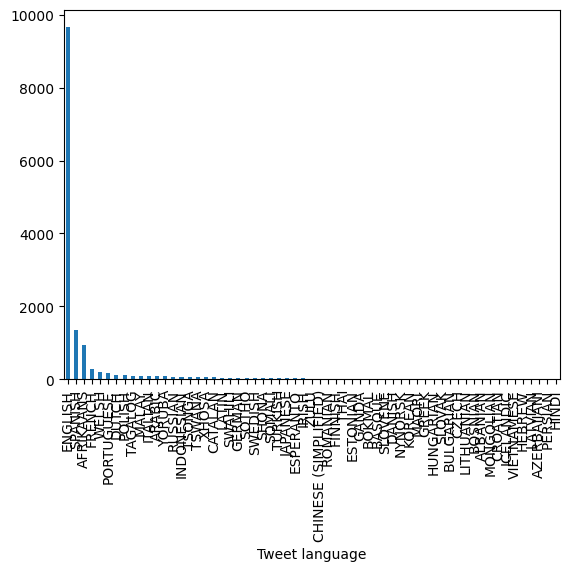

In [226]:
noID['Tweet language'] = noID.apply(lambda row: row['Tweet language'] if row['Tweet language'] != 'CHINESE' else 'CHINESE (SIMPLIFIED)', axis=1)
noID['Tweet language'].value_counts().plot(kind='bar')


<Axes: xlabel='Tweet language'>

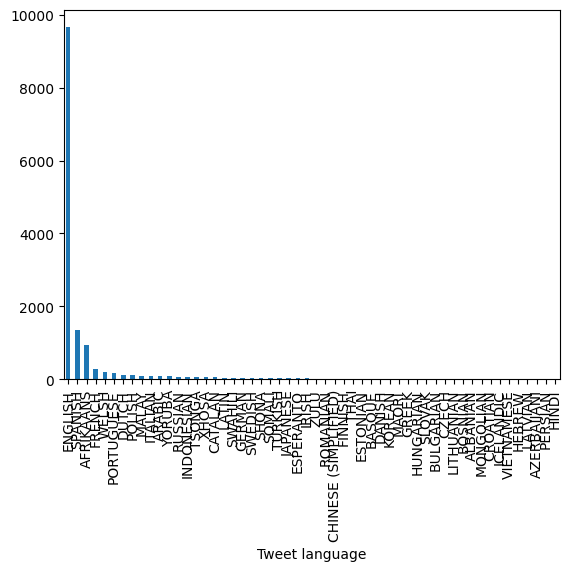

In [227]:
supportedUp = list(map(up, supported))
noUnsupportedLanguages = noID[noID['Tweet language'].isin(supportedUp)].reset_index(drop=True)
noUnsupportedLanguages['Tweet language'].value_counts().plot(kind='bar')

In [228]:
noUnsupportedLanguages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14030 entries, 0 to 14029
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   tweetText          14030 non-null  object 
 1   imageId(s)         14030 non-null  object 
 2   username           14030 non-null  object 
 3   label              14030 non-null  object 
 4   Day sin            14030 non-null  float64
 5   Day cos            14030 non-null  float64
 6   Week sin           14030 non-null  float64
 7   Week cos           14030 non-null  float64
 8   tweetTextBody      14030 non-null  object 
 9   Tweet language     14030 non-null  object 
 10  Confidence         14030 non-null  float64
 11  Length             14030 non-null  int64  
 12  Confidence/Length  14030 non-null  float64
 13  isEnglish          14030 non-null  int32  
 14  cleanedText        14030 non-null  object 
 15  Mentions           14030 non-null  object 
 16  Hashtags           140

In [229]:
noUnsupportedLanguages.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk


So you can see we have only lost about 250 entries of data which is perfectly fine given the volume of the dataset

In [230]:
noUnsupportedLanguages['translatedTweetBody'] = noUnsupportedLanguages.apply(lambda row: row['tweetTextBody'] if row['isEnglish'] else GoogleTranslator(source=row['Tweet language'].lower(), target='english').translate(row['tweetTextBody']), axis=1)
noUnsupportedLanguages.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN,Do you remember the movie: “The Day After Tomo...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux,: Look at Sandy in NY! Tremendous image of the...
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ,"Good photo of Hurricane Sandy, it reminds me o..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH,Scary shit
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk,My fave place in the world 🗽


In [231]:
noUnsupportedLanguages.to_csv('Data/translatedSet.csv', index=False)

I saved this as the time it takes to translate is very very long. 

A few things had to be sorted out with cleaning the text, such as extra spaces, some hashtags being left without anything after it. things like that

Now, we finally move onto natural language processing and turning the text data into something meaningful

To make things easier, we will turn all the text to lowercase

In [238]:
low = noUnsupportedLanguages
low['translatedTweetBody'] = low['translatedTweetBody'].str.lower()
low.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN,do you remember the movie: “the day after tomo...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux,: look at sandy in ny! tremendous image of the...
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ,"good photo of hurricane sandy, it reminds me o..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH,scary shit
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk,my fave place in the world 🗽


In [241]:
nltk.download('punkt')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


True

In [242]:
low['tokens'] = low['translatedTweetBody'].apply(nltk.word_tokenize)
low.head()

TypeError: expected string or bytes-like object

In [243]:
low['translatedTweetBody'] = low['translatedTweetBody'].fillna('')
low.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN,do you remember the movie: “the day after tomo...
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux,: look at sandy in ny! tremendous image of the...
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ,"good photo of hurricane sandy, it reminds me o..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH,scary shit
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk,my fave place in the world 🗽


In [244]:
low['tokens'] = low['translatedTweetBody'].apply(lambda text: nltk.word_tokenize(text) if text != '' else [])

low.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody,tokens
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,0.999413,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day..."
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,0.892622,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im..."
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,0.961577,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ,"good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,0.092067,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH,scary shit,"[scary, shit]"
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,0.174952,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk,my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]"


Next we should remove the stopwords. Because this is a classification task and we are simply trying to draw key information from the text, removing stopworks is ideal. 

In [246]:
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\John\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [247]:
stop_words = set(stopwords.words('english'))

In [248]:
low['Filtered tokens'] = low['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])
low.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,...,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody,tokens,Filtered tokens
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,fake,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,...,108,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r..."
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,fake,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,...,101,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur..."
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,fake,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,...,86,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ,"good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,fake,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,...,13,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH,scary shit,"[scary, shit]","[scary, shit]"
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,fake,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,...,33,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk,my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]"


From here, stemming is useful as it can separate words from their prefixes and suffixes

In [250]:
from nltk.stem import PorterStemmer

In [251]:
porter = PorterStemmer()
low['Stemmed tokens'] = low['Filtered tokens'].apply(lambda tokens: [porter.stem(token) for token in tokens])
low.tail()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,...,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens
14025,@BobombDom *slaps TweetDeck with the PigFish h...,pigFish_01,Da_Vault_Hunter,fake,0.840094,0.542442,-0.996648,-0.081814,*slaps TweetDeck with the PigFish,ENGLISH,...,0.009541,1,@BobombDom *slaps TweetDeck with the PigFish h...,@BobombDom,,http: //t.co/pyHcJn0jwA,*slaps tweetdeck with the pigfish,"[*, slaps, tweetdeck, with, the, pigfish]","[*, slaps, tweetdeck, pigfish]","[*, slap, tweetdeck, pigfish]"
14026,New Species of Fish found in Brazil or just Re...,pigFish_01,DjSituation_RC,fake,-0.999153,0.041149,-0.903505,-0.428578,New Species of Fish found in Brazil or just Re...,ENGLISH,...,0.007910,1,New Species of Fish found in Brazil or just Re...,,,http: //t.co/a6bG8mWcUs,new species of fish found in brazil or just re...,"[new, species, of, fish, found, in, brazil, or...","[new, species, fish, found, brazil, really, go...","[new, speci, fish, found, brazil, realli, good..."
14027,What do we call this? #pigFISH http: \/\/t.co\...,pigFish_01,Vivo1Vuyo,fake,0.259873,-0.965643,-0.757870,-0.652406,What do we call this?,ENGLISH,...,0.008603,1,What do we call this? #pigFISH http: //t.co/4B...,,#pigFISH,http: //t.co/4Bml62OD15,what do we call this?,"[what, do, we, call, this, ?]","[call, ?]","[call, ?]"
14028,Pigfish ? E dopo il pescecane c'è il pesce mai...,pigFish_01,CosimoTarta,fake,-0.849969,0.526832,-0.299021,-0.954247,Pigfish ? E dopo il pescecane c'è il pesce mai...,ITALIAN,...,0.005336,0,Pigfish ? E dopo il pescecane c'è il pesce mai...,,,http: //t.co/hQzWGhyDef,pigfish? and after the dogfish there is the pi...,"[pigfish, ?, and, after, the, dogfish, there, ...","[pigfish, ?, dogfish, pigfish, ?, ?, ?, ?]","[pigfish, ?, dogfish, pigfish, ?, ?, ?, ?]"
14029,For those who can't decide between fish or mea...,pigFish_01,johnszim,fake,-0.933815,-0.357757,-0.171284,-0.985222,For those who can't decide between fish or mea...,ENGLISH,...,0.014628,1,For those who can't decide between fish or mea...,,#Pigfish,http: //t.co/5JBtF54cmg,for those who can't decide between fish or mea...,"[for, those, who, ca, n't, decide, between, fi...","[ca, n't, decide, fish, meat, .....]","[ca, n't, decid, fish, meat, .....]"


In the next steps, how we process this natural langauge depends on what kind of machine learning algorithm we use. 

To decide, at least one will be a neural network using multi-layer perceptrons. 

In [256]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [258]:
fakeOrReal = {
    'fake': 1,
    'humor': 1,
    'real': 0
}

low['label'] = low['label'].replace(fakeOrReal)

low.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,...,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens
0,¿Se acuerdan de la película: “El día después d...,sandyA_fake_46,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,¿Se acuerdan de la película: “El día después d...,SPANISH,...,0.009254,0,¿Se acuerdan de la película: “El día después d...,,#Sandy,http://t.co/JQQeRPwN,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi..."
1,@milenagimon: Miren a Sandy en NY! Tremenda i...,sandyA_fake_09,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,: Miren a Sandy en NY! Tremenda imagen del hu...,SPANISH,...,0.008838,0,@milenagimon: Miren a Sandy en NY! Tremenda i...,@milenagimon,,http://t.co/41jUweux,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica..."
2,"Buena la foto del Huracán Sandy, me recuerda a...",sandyA_fake_09,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,"Buena la foto del Huracán Sandy, me recuerda a...",SPANISH,...,0.011181,0,"Buena la foto del Huracán Sandy, me recuerda a...",,"#ID4,#Sandy",http://t.co/PTdAXABZ,"good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi..."
3,Scary shit #hurricane #NY http://t.co/e4JLBUfH,sandyA_fake_29,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,Scary shit,ENGLISH,...,0.007082,1,Scary shit #hurricane #NY http://t.co/e4JLBUfH,,"#hurricane,#NY",http://t.co/e4JLBUfH,scary shit,"[scary, shit]","[scary, shit]","[scari, shit]"
4,My fave place in the world #nyc #hurricane #sa...,sandyA_fake_15,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,My fave place in the world 🗽,ENGLISH,...,0.005302,1,My fave place in the world #nyc #hurricane #sa...,,"#nyc,#hurricane,#sandy,#statueofliberty",http://t.co/Ex61doZk,my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]"


In [259]:
concise = low.drop(columns=['tweetText','imageId(s)','tweetTextBody','Tweet language','cleanedText','Links'])
concise.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Mentions,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,,#Sandy,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi..."
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,@milenagimon,,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica..."
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,,"#ID4,#Sandy","good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi..."
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,,"#hurricane,#NY",scary shit,"[scary, shit]","[scary, shit]","[scari, shit]"
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,,"#nyc,#hurricane,#sandy,#statueofliberty",my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]"


In [266]:
concise['Mentions'].describe()

count     14030
unique     2171
top            
freq      10224
Name: Mentions, dtype: object

In [267]:
concise['Mentioned'] = concise['Mentions'].apply(lambda x: 1 if x.strip() != '' else 0)
concise.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Mentions,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens,Mentioned
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,,#Sandy,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi...",0
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,@milenagimon,,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica...",1
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,,"#ID4,#Sandy","good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi...",0
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,,"#hurricane,#NY",scary shit,"[scary, shit]","[scary, shit]","[scari, shit]",0
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,,"#nyc,#hurricane,#sandy,#statueofliberty",my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]",0


In [268]:
concise = concise.drop(columns=['Mentions'])
concise.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens,Mentioned
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,#Sandy,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi...",0
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica...",1
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,"#ID4,#Sandy","good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi...",0
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,"#hurricane,#NY",scary shit,"[scary, shit]","[scary, shit]","[scari, shit]",0
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,"#nyc,#hurricane,#sandy,#statueofliberty",my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]",0


In [272]:
concise['Stemmed tokens_str'] = concise['Stemmed tokens'].apply(lambda x: ' '.join(x))
concise.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens,Mentioned,Stemmed tokens_str
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,#Sandy,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi...",0,rememb movi : “ day tomorrow ” ? remind happen...
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica...",1,: look sandi ny ! tremend imag hurrican . look...
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,"#ID4,#Sandy","good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi...",0,"good photo hurrican sandi , remind movi indepe..."
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,"#hurricane,#NY",scary shit,"[scary, shit]","[scary, shit]","[scari, shit]",0,scari shit
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,"#nyc,#hurricane,#sandy,#statueofliberty",my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]",0,fave place world 🗽


In [273]:
def clean_string(input):
    cleanedString = re.sub(r'[^a-zA-Z0-9\s]', '', input)
    return cleanedString


In [274]:
concise['Stemmed tokens_str'] = concise['Stemmed tokens_str'].apply(clean_string)
concise.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens,Mentioned,Stemmed tokens_str
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,#Sandy,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi...",0,rememb movi day tomorrow remind happen hur...
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica...",1,look sandi ny tremend imag hurrican look li...
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,"#ID4,#Sandy","good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi...",0,good photo hurrican sandi remind movi indepen...
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,"#hurricane,#NY",scary shit,"[scary, shit]","[scary, shit]","[scari, shit]",0,scari shit
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,"#nyc,#hurricane,#sandy,#statueofliberty",my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]",0,fave place world


In [275]:
tfidf_vectorizer = TfidfVectorizer()
vectorTest = tfidf_vectorizer.fit_transform(concise['Stemmed tokens_str'])
print(vectorTest)

  (0, 3213)	0.17646462810984379
  (0, 3015)	0.36939544860505974
  (0, 4941)	0.4898900767725685
  (0, 5953)	0.3978574265869595
  (0, 2017)	0.3468026842722962
  (0, 4120)	0.37832300250875456
  (0, 4940)	0.413187635729315
  (1, 5067)	0.1752611476972838
  (1, 3289)	0.4031553120048033
  (1, 4871)	0.24040103269282728
  (1, 3698)	0.24770923445438803
  (1, 3253)	0.2475643909990684
  (1, 6015)	0.477148469279646
  (1, 4321)	0.24585625225098112
  (1, 5122)	0.11977486848810452
  (1, 3775)	0.47183030962569117
  (1, 3213)	0.14428361109814342
  (1, 2017)	0.2835579241081059
  (2, 4585)	0.22923597092862683
  (2, 2873)	0.3292017323152698
  (2, 3289)	0.5052536237903541
  (2, 5122)	0.1501076248795821
  (2, 3213)	0.1808231596859787
  (2, 4941)	0.5019899598557624
  (2, 2017)	0.35536842612254543
  :	:
  (14021, 1022)	0.26437929849145786
  (14021, 1015)	0.3117843605377387
  (14021, 3167)	0.23377283892612594
  (14021, 4871)	0.1894215955660739
  (14023, 4609)	1.0
  (14025, 6072)	0.6065537768659751
  (14025, 542

So we have now created a vectorisation for the text in the tweet. Despite that, we need something for the hashtags. The problem is that hashtags are usually quite specific to the event itself. A simple bit of data is just how many hashtags there are. 

In [279]:
concise['HashCount'] = concise['Hashtags'].apply(lambda x: len(x.split(',')) if x != '' else 0)
concise.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens,Mentioned,Stemmed tokens_str,HashCount
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,#Sandy,do you remember the movie: “the day after tomo...,"[do, you, remember, the, movie, :, “, the, day...","[remember, movie, :, “, day, tomorrow, ”, ?, r...","[rememb, movi, :, “, day, tomorrow, ”, ?, remi...",0,rememb movi day tomorrow remind happen hur...,1
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,,: look at sandy in ny! tremendous image of the...,"[:, look, at, sandy, in, ny, !, tremendous, im...","[:, look, sandy, ny, !, tremendous, image, hur...","[:, look, sandi, ny, !, tremend, imag, hurrica...",1,look sandi ny tremend imag hurrican look li...,0
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,"#ID4,#Sandy","good photo of hurricane sandy, it reminds me o...","[good, photo, of, hurricane, sandy, ,, it, rem...","[good, photo, hurricane, sandy, ,, reminds, mo...","[good, photo, hurrican, sandi, ,, remind, movi...",0,good photo hurrican sandi remind movi indepen...,2
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,"#hurricane,#NY",scary shit,"[scary, shit]","[scary, shit]","[scari, shit]",0,scari shit,2
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,"#nyc,#hurricane,#sandy,#statueofliberty",my fave place in the world 🗽,"[my, fave, place, in, the, world, 🗽]","[fave, place, world, 🗽]","[fave, place, world, 🗽]",0,fave place world,4


In [282]:
notags = concise.drop(columns=['Hashtags','Stemmed tokens','Filtered tokens','tokens','translatedTweetBody'])
notags.tail()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Mentioned,Stemmed tokens_str,HashCount
14025,Da_Vault_Hunter,1,0.840094,0.542442,-0.996648,-0.081814,0.333921,35,0.009541,1,1,slap tweetdeck pigfish,0
14026,DjSituation_RC,1,-0.999153,0.041149,-0.903505,-0.428578,0.775199,98,0.007910,1,0,new speci fish found brazil realli good photos...,0
14027,Vivo1Vuyo,1,0.259873,-0.965643,-0.757870,-0.652406,0.197877,23,0.008603,1,0,call,1
14028,CosimoTarta,1,-0.849969,0.526832,-0.299021,-0.954247,0.293495,55,0.005336,0,0,pigfish dogfish pigfish,0
14029,johnszim,1,-0.933815,-0.357757,-0.171284,-0.985222,0.775301,53,0.014628,1,0,ca nt decid fish meat,1


In [285]:
combinedVectors = pd.concat([notags,pd.DataFrame(vectorTest.toarray())],axis=1)
combinedVectors.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,...,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582
0,iAnnieM,1,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CarlosVerareal,1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,LucasPalape,1,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Haaaaarryyy,1,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,princess__natt,1,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This is almost there, but a big problem is the fact that we have almost 6500 columns. We need to do some more feature selection with the text to try to make things better in the dimension department. 

In [286]:
from sklearn.feature_selection import SelectKBest, f_classif

In [287]:
labels = combinedVectors['label']
labels.head()

0    1
1    1
2    1
3    1
4    1
Name: label, dtype: int64

In [289]:
labels.shape

(14030,)

In [290]:
firstTest = combinedVectors.drop(columns=['label', 'username'])
firstTest.head()

,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Mentioned,Stemmed tokens_str,...,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582
0,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,0,rememb movi day tomorrow remind happen hur...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,1,look sandi ny tremend imag hurrican look li...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,0,good photo hurrican sandi remind movi indepen...,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,0,scari shit,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,0,fave place world,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [301]:
firstTest.columns = firstTest.columns.astype(str)
firstTest = firstTest.drop(columns=['Stemmed tokens_str'])
firstTest.head()

,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Mentioned,HashCount,...,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582
0,-0.366434,0.930444,-0.961607,-0.274429,0.999413,108,0.009254,0,0,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,101,0.008838,0,1,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.998820,0.048559,-0.903958,-0.427621,0.961577,86,0.011181,0,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.946156,0.323711,-0.920395,-0.390989,0.092067,13,0.007082,1,0,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.748859,0.662729,-0.940972,-0.338484,0.174952,33,0.005302,1,0,4,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Before doing automatic feature selection, we should have standardise our data

In [309]:
from sklearn.preprocessing import StandardScaler

nonStandardFeatures = firstTest[['Day sin','Day cos','Week sin','Week cos', 'Confidence', 'Length', 'isEnglish', 'Mentioned']]

standardFeatures = firstTest[['Confidence/Length', 'HashCount']]
scaler = StandardScaler()
firstTestStandardized = scaler.fit_transform(standardFeatures)

standard = pd.DataFrame(firstTestStandardized, columns=standardFeatures.columns)

together = pd.concat([nonStandardFeatures,standard],axis=1)

alltogether = pd.concat([together,pd.DataFrame(vectorTest.toarray())],axis=1)

def tweetLength(no):
    return no / 280

alltogether['Length'] = alltogether['Length'].apply(tweetLength)

alltogether.head()


,Day sin,Day cos,Week sin,Week cos,Confidence,Length,isEnglish,Mentioned,Confidence/Length,HashCount,...,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582
0,-0.366434,0.930444,-0.961607,-0.274429,0.999413,0.385714,0,0,-0.003263,-0.253341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,0.360714,0,1,-0.064750,-0.752060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.998820,0.048559,-0.903958,-0.427621,0.961577,0.307143,0,0,0.281613,0.245378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.946156,0.323711,-0.920395,-0.390989,0.092067,0.046429,1,0,-0.324267,0.245378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.748859,0.662729,-0.940972,-0.338484,0.174952,0.117857,1,0,-0.587445,1.242817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [310]:
alltogether.tail()

,Day sin,Day cos,Week sin,Week cos,Confidence,Length,isEnglish,Mentioned,Confidence/Length,HashCount,...,6573,6574,6575,6576,6577,6578,6579,6580,6581,6582
14025,0.840094,0.542442,-0.996648,-0.081814,0.333921,0.125000,1,1,0.039124,-0.752060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14026,-0.999153,0.041149,-0.903505,-0.428578,0.775199,0.350000,1,0,-0.201866,-0.752060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14027,0.259873,-0.965643,-0.757870,-0.652406,0.197877,0.082143,1,0,-0.099410,-0.253341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14028,-0.849969,0.526832,-0.299021,-0.954247,0.293495,0.196429,0,0,-0.582319,-0.752060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14029,-0.933815,-0.357757,-0.171284,-0.985222,0.775301,0.189286,1,0,0.791145,-0.253341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [317]:
alltogether.columns = alltogether.columns.astype(str)
k_best = SelectKBest(f_classif, k=1000)
X_tfidf_selected = k_best.fit_transform(alltogether, labels)

selected_features_mask = k_best.get_support()
selected_feature_names = alltogether.columns[selected_features_mask]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['Day sin', 'Week sin', 'Week cos', 'Confidence', 'Length', 'isEnglish',
       'Mentioned', 'Confidence/Length', 'HashCount', '89',
       ...
       '6533', '6537', '6542', '6547', '6558', '6567', '6570', '6574', '6576',
       '6578'],
      dtype='object', length=1000)


Despite what the k_best says, I want to include all the data that I added. But I want to know which word vectors I should include. A rough rule of thumb could be to have at least 10 times the entries as features, so I think 500 is probably a good starting point so we have more like 20 times the entries. 

In [437]:
#vector = pd.DataFrame(vectorTest.toarray())
#vector.columns = vector.columns.astype(str)
k_best = SelectKBest(f_classif, k=1200)
X_tfidf_selected = k_best.fit_transform(vector, labels)

selected_features_mask = k_best.get_support()
selected_feature_names = vector.columns[selected_features_mask]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: Index(['89', '90', '102', '111', '122', '129', '142', '151', '152', '165',
       ...
       '6537', '6542', '6547', '6558', '6567', '6570', '6574', '6576', '6577',
       '6578'],
      dtype='object', length=1200)


So now we know what apparently the top 500 features are for the work tf-idf vectorisation. 

In [438]:
selectedVector = vector.loc[:, selected_features_mask]

alltogether = pd.concat([together,pd.DataFrame(selectedVector)],axis=1)

alltogether['Length'] = alltogether['Length'].apply(tweetLength)

alltogether.head()


,Day sin,Day cos,Week sin,Week cos,Confidence,Length,isEnglish,Mentioned,Confidence/Length,HashCount,...,6537,6542,6547,6558,6567,6570,6574,6576,6577,6578
0,-0.366434,0.930444,-0.961607,-0.274429,0.999413,0.385714,0,0,-0.003263,-0.253341,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,0.360714,0,1,-0.064750,-0.752060,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.998820,0.048559,-0.903958,-0.427621,0.961577,0.307143,0,0,0.281613,0.245378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,-0.946156,0.323711,-0.920395,-0.390989,0.092067,0.046429,1,0,-0.324267,0.245378,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.748859,0.662729,-0.940972,-0.338484,0.174952,0.117857,1,0,-0.587445,1.242817,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [439]:
alltogether.shape

(14030, 1210)

In [440]:
alltogether.to_csv('Data/alltogether1200.csv', index=False)

So now we have fully vectorised and standardised data. We can finally actually start things. First we need to split off a test set for data validation while training. And then we are good to go!

We still have some actual data available for testing so we will set test size to 0.1

In [441]:
X_train, X_test, y_train, y_test = train_test_split(alltogether, labels, test_size=0.1, random_state=33, stratify=labels)

In [442]:
from tensorflow.keras import layers, models

X_train_val = X_train.values
y_train_val = y_train.values
X_test_val = X_test.values
y_test_val = y_test.values

alltogether_val = alltogether.values
labels_val = labels.values

In [443]:
model = models.Sequential()
model.add(layers.Dense(510, activation='leaky_relu', input_shape=(X_train_val.shape[1],)))
model.add(layers.Dense(300, activation='relu'))
model.add(layers.Dense(150, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

We are using a sigmoid function at the end because this is binary classification. I'm going with 510 neurons to start as that is the number of features. 'adam' is generally the most popular optimmiser, and binary crossentropy works very well for binary classification. I did try binary focal crossentropy however I don't think it worked as well. 

In [444]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [445]:
model.fit(alltogether_val, labels_val, epochs=10, batch_size=16, validation_split=0.1)

Epoch 1/10
790/790 [==============================] - 6s 7ms/step - loss: 0.3168 - accuracy: 0.8627 - val_loss: 0.6538 - val_accuracy: 0.7042
Epoch 2/10
790/790 [==============================] - 5s 6ms/step - loss: 0.2288 - accuracy: 0.9047 - val_loss: 0.7364 - val_accuracy: 0.7092
Epoch 3/10
790/790 [==============================] - 5s 6ms/step - loss: 0.2049 - accuracy: 0.9119 - val_loss: 1.1256 - val_accuracy: 0.6108
Epoch 4/10
790/790 [==============================] - 5s 7ms/step - loss: 0.1885 - accuracy: 0.9168 - val_loss: 0.7287 - val_accuracy: 0.7341
Epoch 5/10
790/790 [==============================] - 5s 7ms/step - loss: 0.1726 - accuracy: 0.9229 - val_loss: 0.9497 - val_accuracy: 0.7320
Epoch 6/10
790/790 [==============================] - 5s 7ms/step - loss: 0.1632 - accuracy: 0.9285 - val_loss: 0.8960 - val_accuracy: 0.7413
Epoch 7/10
790/790 [==============================] - 6s 7ms/step - loss: 0.1551 - accuracy: 0.9313 - val_loss: 1.4703 - val_accuracy: 0.6287
Epoch 

So here the neural network works fairly well. It currently is getting about 95% accuracy on the data. However this may change a lot when the true test data comes in. 

The second algorithm I wanted to try was an SVM. They are vey well suited to classification problems like this. 

It was between an svm and logistic regression, but I decided that svm was more interesting

In [446]:
from sklearn import svm

In [447]:
clf = svm.SVC()
clf.fit(X_train_val, y_train_val)

SVC()

In [449]:
from sklearn import metrics
y_pred_val = clf.predict(X_test_val)

print("Accuracy:", metrics.accuracy_score(y_test_val, y_pred_val))

print("F1Score:", metrics.f1_score(y_test_val,y_pred_val))

Accuracy: 0.8738417676407698
F1Score: 0.9108312342569269


Okay so a support vector machine ended up getting about 87% against test data generated from the origianl data sample. Now we really need to see how these models behave when presented with the data from the test dataset. 

## Test dataset (This part also essentially covers a streamlined way to format the dataset)

In [392]:
file_path_test = 'Data/mediaeval-2015-testset.txt'
test_raw = pd.read_csv(file_path_test, sep='\t')
test_raw.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake


In [393]:
print("Number of columns {}".format(len(test_raw.columns)))
print("Number of rows {}".format(len(test_raw)))

Number of columns 7
Number of rows 3755


So our test data is 3755 entries of the same formatted stuff

In [394]:
df_T = test_raw
df_T.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake


In [395]:
format_string = "%a %b %d %H:%M:%S %z %Y"
secondary_string = "%a %b %d %H: %M: %S %z %Y"

df_T["dateTime"] = pd.to_datetime(df_T['timestamp'], format=format_string, errors='coerce')
df_T["dateTime"] = df_T["dateTime"].fillna(pd.to_datetime(df_T['timestamp'], format=secondary_string, errors='coerce'))

df_T.head()

,tweetId,tweetText,userId,imageId(s),username,timestamp,label,dateTime
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,Fri Mar 20 09:45:43 +0000 2015,fake,2015-03-20 09:45:43+00:00
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,Fri Mar 20 11:04:02 +0000 2015,fake,2015-03-20 11:04:02+00:00
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,Fri Mar 20 12:10:06 +0000 2015,fake,2015-03-20 12:10:06+00:00
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,Fri Mar 20 09:12:41 +0000 2015,fake,2015-03-20 09:12:41+00:00
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,Fri Mar 20 17:44:11 +0000 2015,fake,2015-03-20 17:44:11+00:00


In [396]:
new_T = df_T.drop(columns=['timestamp'])

new_T["secondsTime"] = new_T["dateTime"].map(pd.Timestamp.timestamp)

day = 24*60*60
week = 7*day

new_T["Day sin"] = np.sin(new_T["secondsTime"] * (2 * np.pi / day))
new_T["Day cos"] = np.cos(new_T["secondsTime"] * (2 * np.pi / day))
new_T["Week sin"] = np.sin(new_T["secondsTime"] * (2 * np.pi / week))
new_T["Week cos"] = np.cos(new_T["secondsTime"] * (2 * np.pi / week))

new_T.head()

,tweetId,tweetText,userId,imageId(s),username,label,dateTime,secondsTime,Day sin,Day cos,Week sin,Week cos
0,578854927457349632,kereeen RT @Shyman33: Eclipse from ISS.... htt...,70824972,eclipse_01,peay_s,fake,2015-03-20 09:45:43+00:00,1.426845e+09,0.552967,-0.833203,0.952911,0.303251
1,578874632670953472,Absolutely beautiful! RT @Shyman33: Eclipse fr...,344707006,eclipse_01,JaredUcanChange,fake,2015-03-20 11:04:02+00:00,1.426849e+09,0.241781,-0.970331,0.966573,0.256390
2,578891261353984000,“@Shyman33: Eclipse from ISS.... http://t.co/C...,224839607,eclipse_01,tpjp1231,fake,2015-03-20 12:10:06+00:00,1.426853e+09,-0.044055,-0.999029,0.976309,0.216379
3,578846612312748032,Eclipse from ISS.... http://t.co/En87OtvsU6,134543073,eclipse_01,Shyman33,fake,2015-03-20 09:12:41+00:00,1.426843e+09,0.666912,-0.745137,0.946465,0.322807
4,578975333841551360,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,1150728872,eclipse_01,Epimethee_,fake,2015-03-20 17:44:11+00:00,1.426873e+09,-0.997620,-0.068958,0.999951,0.009859


In [397]:
newTime_T = new_T.drop(columns=['dateTime','secondsTime'])

noID_T = newTime_T.drop(columns=['tweetId','userId'])

noID_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859


In [399]:
noID_T["tweetTextBody"] = noID_T["tweetText"].apply(getTweetBodyFixed)
noID_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...


In [400]:
noID_T[['Tweet language','Confidence']] = noID_T["tweetTextBody"].apply(lambda x: pd.Series(determineLanguage(x)))
noID_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,0.087908
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,0.755086
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,1.000000
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,0.117399
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,0.918624


In [401]:
noID_T["Length"] = noID_T["tweetTextBody"].apply(lambda x: pd.Series(len(x)))

noID_T["Confidence/Length"] = noID_T["Confidence"] / noID_T["Length"]

noID_T['isEnglish'] = (noID_T['Tweet language'] == "ENGLISH").astype(int)

noID_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,0.087908,34,0.002586,0
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,0.755086,48,0.015731,1
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,1.000000,52,0.019231,0
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,0.117399,21,0.005590,1
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,0.918624,81,0.011341,0


In [402]:
noID_T['cleanedText'] = noID_T['tweetText'].apply(getCleanedTweetText)

noID_T['Mentions'] = noID_T['cleanedText'].apply(getMentions)
noID_T['Hashtags'] = noID_T['cleanedText'].apply(getHashtags)
noID_T['Links'] = noID_T['cleanedText'].apply(getLinks)

noID_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,0.087908,34,0.002586,0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,@Shyman33,,http://t.co/je2hcFpVfN
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,0.755086,48,0.015731,1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,@Shyman33,,http://t.co/oqwtTL0ThS
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,1.000000,52,0.019231,0,“@Shyman33: Eclipse from ISS.... http://t.co/C...,@Shyman33,,http://t.co/C0VfboScRj”
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,0.117399,21,0.005590,1,Eclipse from ISS.... http://t.co/En87OtvsU6,,,http://t.co/En87OtvsU6
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,0.918624,81,0.011341,0,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,@ebonfigli,,http://t.co/yNBN7c4O51


In [406]:
supported = GoogleTranslator().get_supported_languages()
def lowText(text):
    return text.lower()



available_T = list(map(lowText,noID_T['Tweet language'].unique()))

res_T = np.setdiff1d(available_T, supported).tolist()

noID_T['Tweet language'] = noID_T.apply(lambda row: row['Tweet language'] if row['Tweet language'] != 'CHINESE' else 'CHINESE (SIMPLIFIED)', axis=1)


supportedUp_T = list(map(up, supported))
noUnsupportedLanguages_T = noID_T[noID_T['Tweet language'].isin(supportedUp_T)].reset_index(drop=True)

noUnsupportedLanguages_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,0.087908,34,0.002586,0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,@Shyman33,,http://t.co/je2hcFpVfN
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,0.755086,48,0.015731,1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,@Shyman33,,http://t.co/oqwtTL0ThS
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,1.000000,52,0.019231,0,“@Shyman33: Eclipse from ISS.... http://t.co/C...,@Shyman33,,http://t.co/C0VfboScRj”
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,0.117399,21,0.005590,1,Eclipse from ISS.... http://t.co/En87OtvsU6,,,http://t.co/En87OtvsU6
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,0.918624,81,0.011341,0,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,@ebonfigli,,http://t.co/yNBN7c4O51


In [407]:
noUnsupportedLanguages_T['translatedTweetBody'] = noUnsupportedLanguages_T.apply(lambda row: row['tweetTextBody'] if row['isEnglish'] else GoogleTranslator(source=row['Tweet language'].lower(), target='english').translate(row['tweetTextBody']), axis=1)
noUnsupportedLanguages_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,0.087908,34,0.002586,0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,@Shyman33,,http://t.co/je2hcFpVfN,kereeen RT : Eclipse from ISS....
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,0.755086,48,0.015731,1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,@Shyman33,,http://t.co/oqwtTL0ThS,Absolutely beautiful! RT : Eclipse from ISS....
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,1.000000,52,0.019231,0,“@Shyman33: Eclipse from ISS.... http://t.co/C...,@Shyman33,,http://t.co/C0VfboScRj”,“: Eclipse from ISS.... 3.20 solar eclipse see...
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,0.117399,21,0.005590,1,Eclipse from ISS.... http://t.co/En87OtvsU6,,,http://t.co/En87OtvsU6,Eclipse from ISS....
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,0.918624,81,0.011341,0,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,@ebonfigli,,http://t.co/yNBN7c4O51,: Eclipse seen from the ISS... Something else....


In [408]:
low_T = noUnsupportedLanguages_T
low_T['translatedTweetBody'] = low_T['translatedTweetBody'].str.lower()

low_T['translatedTweetBody'] = low_T['translatedTweetBody'].fillna('')

low_T['tokens'] = low_T['translatedTweetBody'].apply(lambda text: nltk.word_tokenize(text) if text != '' else [])

low_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,Confidence,Length,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody,tokens
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,fake,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,0.087908,34,0.002586,0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,@Shyman33,,http://t.co/je2hcFpVfN,kereeen rt : eclipse from iss....,"[kereeen, rt, :, eclipse, from, iss, ....]"
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,fake,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,0.755086,48,0.015731,1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,@Shyman33,,http://t.co/oqwtTL0ThS,absolutely beautiful! rt : eclipse from iss....,"[absolutely, beautiful, !, rt, :, eclipse, fro..."
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,fake,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,1.000000,52,0.019231,0,“@Shyman33: Eclipse from ISS.... http://t.co/C...,@Shyman33,,http://t.co/C0VfboScRj”,“: eclipse from iss.... 3.20 solar eclipse see...,"[“, :, eclipse, from, iss, ...., 3.20, solar, ..."
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,fake,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,0.117399,21,0.005590,1,Eclipse from ISS.... http://t.co/En87OtvsU6,,,http://t.co/En87OtvsU6,eclipse from iss....,"[eclipse, from, iss, ....]"
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,fake,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,0.918624,81,0.011341,0,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,@ebonfigli,,http://t.co/yNBN7c4O51,: eclipse seen from the iss... something else....,"[:, eclipse, seen, from, the, iss, ..., someth..."


In [409]:
stop_words = set(stopwords.words('english'))

low_T['Filtered tokens'] = low_T['tokens'].apply(lambda tokens: [token for token in tokens if token not in stop_words])

porter = PorterStemmer()
low_T['Stemmed tokens'] = low_T['Filtered tokens'].apply(lambda tokens: [porter.stem(token) for token in tokens])



fakeOrReal = {
    'fake': 1,
    'humor': 1,
    'real': 0
}

low_T['label'] = low_T['label'].replace(fakeOrReal)

low_T.head()

,tweetText,imageId(s),username,label,Day sin,Day cos,Week sin,Week cos,tweetTextBody,Tweet language,...,Confidence/Length,isEnglish,cleanedText,Mentions,Hashtags,Links,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens
0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,eclipse_01,peay_s,1,0.552967,-0.833203,0.952911,0.303251,kereeen RT : Eclipse from ISS....,DUTCH,...,0.002586,0,kereeen RT @Shyman33: Eclipse from ISS.... htt...,@Shyman33,,http://t.co/je2hcFpVfN,kereeen rt : eclipse from iss....,"[kereeen, rt, :, eclipse, from, iss, ....]","[kereeen, rt, :, eclipse, iss, ....]","[kereeen, rt, :, eclips, iss, ....]"
1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,eclipse_01,JaredUcanChange,1,0.241781,-0.970331,0.966573,0.256390,Absolutely beautiful! RT : Eclipse from ISS....,ENGLISH,...,0.015731,1,Absolutely beautiful! RT @Shyman33: Eclipse fr...,@Shyman33,,http://t.co/oqwtTL0ThS,absolutely beautiful! rt : eclipse from iss....,"[absolutely, beautiful, !, rt, :, eclipse, fro...","[absolutely, beautiful, !, rt, :, eclipse, iss...","[absolut, beauti, !, rt, :, eclips, iss, ....]"
2,“@Shyman33: Eclipse from ISS.... http://t.co/C...,eclipse_01,tpjp1231,1,-0.044055,-0.999029,0.976309,0.216379,“: Eclipse from ISS.... 우주에서본 3.20 일식 Wow! am...,KOREAN,...,0.019231,0,“@Shyman33: Eclipse from ISS.... http://t.co/C...,@Shyman33,,http://t.co/C0VfboScRj”,“: eclipse from iss.... 3.20 solar eclipse see...,"[“, :, eclipse, from, iss, ...., 3.20, solar, ...","[“, :, eclipse, iss, ...., 3.20, solar, eclips...","[“, :, eclips, iss, ...., 3.20, solar, eclips,..."
3,Eclipse from ISS.... http://t.co/En87OtvsU6,eclipse_01,Shyman33,1,0.666912,-0.745137,0.946465,0.322807,Eclipse from ISS....,ENGLISH,...,0.005590,1,Eclipse from ISS.... http://t.co/En87OtvsU6,,,http://t.co/En87OtvsU6,eclipse from iss....,"[eclipse, from, iss, ....]","[eclipse, iss, ....]","[eclips, iss, ....]"
4,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,eclipse_01,Epimethee_,1,-0.997620,-0.068958,0.999951,0.009859,: Éclipse vue de l'ISS... Autre chose... La ...,FRENCH,...,0.011341,0,@ebonfigli: Éclipse vue de l'ISS... Autre chos...,@ebonfigli,,http://t.co/yNBN7c4O51,: eclipse seen from the iss... something else....,"[:, eclipse, seen, from, the, iss, ..., someth...","[:, eclipse, seen, iss, ..., something, else, ...","[:, eclips, seen, iss, ..., someth, els, ..., ..."


In [410]:
concise_T = low_T.drop(columns=['tweetText','imageId(s)','tweetTextBody','Tweet language','cleanedText','Links'])


concise_T['Mentioned'] = concise_T['Mentions'].apply(lambda x: 1 if x.strip() != '' else 0)


concise_T = concise_T.drop(columns=['Mentions'])

concise_T['Stemmed tokens_str'] = concise_T['Stemmed tokens'].apply(lambda x: ' '.join(x))

concise_T['Stemmed tokens_str'] = concise_T['Stemmed tokens_str'].apply(clean_string)

concise_T.head()

,username,label,Day sin,Day cos,Week sin,Week cos,Confidence,Length,Confidence/Length,isEnglish,Hashtags,translatedTweetBody,tokens,Filtered tokens,Stemmed tokens,Mentioned,Stemmed tokens_str
0,peay_s,1,0.552967,-0.833203,0.952911,0.303251,0.087908,34,0.002586,0,,kereeen rt : eclipse from iss....,"[kereeen, rt, :, eclipse, from, iss, ....]","[kereeen, rt, :, eclipse, iss, ....]","[kereeen, rt, :, eclips, iss, ....]",1,kereeen rt eclips iss
1,JaredUcanChange,1,0.241781,-0.970331,0.966573,0.256390,0.755086,48,0.015731,1,,absolutely beautiful! rt : eclipse from iss....,"[absolutely, beautiful, !, rt, :, eclipse, fro...","[absolutely, beautiful, !, rt, :, eclipse, iss...","[absolut, beauti, !, rt, :, eclips, iss, ....]",1,absolut beauti rt eclips iss
2,tpjp1231,1,-0.044055,-0.999029,0.976309,0.216379,1.000000,52,0.019231,0,,“: eclipse from iss.... 3.20 solar eclipse see...,"[“, :, eclipse, from, iss, ...., 3.20, solar, ...","[“, :, eclipse, iss, ...., 3.20, solar, eclips...","[“, :, eclips, iss, ...., 3.20, solar, eclips,...",1,eclips iss 320 solar eclips seen space wow ...
3,Shyman33,1,0.666912,-0.745137,0.946465,0.322807,0.117399,21,0.005590,1,,eclipse from iss....,"[eclipse, from, iss, ....]","[eclipse, iss, ....]","[eclips, iss, ....]",0,eclips iss
4,Epimethee_,1,-0.997620,-0.068958,0.999951,0.009859,0.918624,81,0.011341,0,,: eclipse seen from the iss... something else....,"[:, eclipse, seen, from, the, iss, ..., someth...","[:, eclipse, seen, iss, ..., something, else, ...","[:, eclips, seen, iss, ..., someth, els, ..., ...",1,eclips seen iss someth els divin creation l...


In [411]:
vectorTest_T = tfidf_vectorizer.transform(concise_T['Stemmed tokens_str'])

concise_T['HashCount'] = concise_T['Hashtags'].apply(lambda x: len(x.split(',')) if x != '' else 0)


notags_T = concise_T.drop(columns=['Hashtags','Stemmed tokens','Filtered tokens','tokens','translatedTweetBody'])

labels_T = notags_T['label']

In [412]:
nonStandardFeatures_T = notags_T[['Day sin','Day cos','Week sin','Week cos', 'Confidence', 'Length', 'isEnglish', 'Mentioned']]

standard_TFeatures_T = notags_T[['Confidence/Length', 'HashCount']]

firstTestStandardized_T = scaler.transform(standard_TFeatures_T)

standard_T = pd.DataFrame(firstTestStandardized_T, columns=standard_TFeatures_T.columns)

together_T = pd.concat([nonStandardFeatures_T,standard_T],axis=1)

In [413]:
vector_T = pd.DataFrame(vectorTest_T.toarray())
vector_T.columns = vector_T.columns.astype(str)

In [450]:
X_tfidf_selected_T = k_best.transform(vector_T)

selected_features_mask = k_best.get_support()


selectedVector_T = X_tfidf_selected_T

In [451]:
alltogether_T = pd.concat([together_T,pd.DataFrame(selectedVector_T)],axis=1)

alltogether_T['Length'] = alltogether_T['Length'].apply(tweetLength)

alltogether_T.head()

,Day sin,Day cos,Week sin,Week cos,Confidence,Length,isEnglish,Mentioned,Confidence/Length,HashCount,...,1190,1191,1192,1193,1194,1195,1196,1197,1198,1199
0,0.552967,-0.833203,0.952911,0.303251,0.087908,0.121429,0,1,-0.988908,-0.75206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.241781,-0.970331,0.966573,0.256390,0.755086,0.171429,1,1,0.954126,-0.75206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-0.044055,-0.999029,0.976309,0.216379,1.000000,0.185714,0,1,1.471434,-0.75206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.666912,-0.745137,0.946465,0.322807,0.117399,0.075000,1,0,-0.544750,-0.75206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,-0.997620,-0.068958,0.999951,0.009859,0.918624,0.289286,0,1,0.305250,-0.75206,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [452]:
alltogether_T.shape

(3240, 1210)

In [453]:
alltogether_T.to_csv('Data/alltogether_T.csv', index=False)

So now we have the test data, and we can run it through the machine learning algorithms to see how effective it is. 

We will start by retraining the SVM with all the training data. And then testing it against the test set. 

In [520]:
svmModel = svm.SVC()
svmModel.fit(alltogether_val, labels_val)

SVC()

In [521]:
alltogether_T_val = alltogether_T.values
labels_T_val = labels_T.values

y_pred_val_T = clf.predict(alltogether_T_val)

print("Accuracy:", metrics.accuracy_score(labels_T_val, y_pred_val_T))

print("F1 Score:", metrics.f1_score(labels_T_val, y_pred_val_T))

Accuracy: 0.6614197530864198
F1 Score: 0.768125132107377


We the svm as we can see is overfitting somewhat. it is only getting about 66% accuracy compared to the 82% from the training set test data. 

Perhaps the neural network will do better

In [531]:
from keras import backend as K

def f1_score(y_pred, y_true):
    """
    Custom F1 score metric for Keras.
    """
    #Convert predictions to binary values (0 or 1)
    y_pred = K.round(y_pred + 0.2)

    # Calculate true positives, false positives, and false negatives
    tp = K.sum(K.round(y_true * y_pred))
    fp = K.sum(K.round(K.clip(y_pred - y_true, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true - y_pred, 0, 1)))

    # Calculate precision and recall
    precision = tp / (tp + fp + K.epsilon())
    recall = tp / (tp + fn + K.epsilon())

    # Calculate F1 score
    f1 = 2 * (precision * recall) / (precision + recall + K.epsilon())

    return f1

In [483]:
from keras.layers import Dropout

In [508]:
model2 = models.Sequential()
model2.add(layers.Dense(1210, activation='leaky_relu', input_shape=(alltogether_val.shape[1:])))
model2.add(layers.Dense(500, activation='relu'))
model2.add(Dropout(0.5))
model2.add(layers.Dense(250, activation='tanh'))
model2.add(layers.Dense(1, activation='sigmoid'))

model2.compile(optimizer=tf.keras.optimizers.Ftrl(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy', f1_score])
model2.fit(alltogether_val, labels_val, epochs=10, batch_size=32, validation_split=0.2)

Epoch 1/10
351/351 [==============================] - 9s 23ms/step - loss: 0.6900 - accuracy: 0.6742 - f1_score: 0.8028 - val_loss: 0.6911 - val_accuracy: 0.5723 - val_f1_score: 0.5777
Epoch 2/10
351/351 [==============================] - 8s 23ms/step - loss: 0.6870 - accuracy: 0.6751 - f1_score: 0.8034 - val_loss: 0.6903 - val_accuracy: 0.5723 - val_f1_score: 0.5777
Epoch 3/10
351/351 [==============================] - 8s 23ms/step - loss: 0.6850 - accuracy: 0.6751 - f1_score: 0.8029 - val_loss: 0.6897 - val_accuracy: 0.5723 - val_f1_score: 0.5777
Epoch 4/10
351/351 [==============================] - 8s 23ms/step - loss: 0.6835 - accuracy: 0.6751 - f1_score: 0.8028 - val_loss: 0.6892 - val_accuracy: 0.5723 - val_f1_score: 0.5777
Epoch 5/10
351/351 [==============================] - 8s 24ms/step - loss: 0.6822 - accuracy: 0.6751 - f1_score: 0.8032 - val_loss: 0.6887 - val_accuracy: 0.5723 - val_f1_score: 0.5777
Epoch 6/10
351/351 [==============================] - 9s 26ms/step - loss: 

In [511]:
predictions = model2.evaluate(alltogether_T_val,labels_T_val)

prediction = model2.predict(alltogether_T_val)

print(f1_score(labels_T_val,prediction))

#print(predictions)

102/102 [==============================] - 0s 2ms/step
tf.Tensor(0.77179676, shape=(), dtype=float32)


## Below is an experment to see how the model would work without the work information. 

In [533]:
noWords = alltogether[['Day sin','Day cos','Week sin','Week cos','Confidence','Length','isEnglish','Mentioned','Confidence/Length','HashCount']]

noWords.head()

,Day sin,Day cos,Week sin,Week cos,Confidence,Length,isEnglish,Mentioned,Confidence/Length,HashCount
0,-0.366434,0.930444,-0.961607,-0.274429,0.999413,0.385714,0,0,-0.003263,-0.253341
1,-0.951885,0.306457,-0.919377,-0.393378,0.892622,0.360714,0,1,-0.064750,-0.752060
2,-0.998820,0.048559,-0.903958,-0.427621,0.961577,0.307143,0,0,0.281613,0.245378
3,-0.946156,0.323711,-0.920395,-0.390989,0.092067,0.046429,1,0,-0.324267,0.245378
4,-0.748859,0.662729,-0.940972,-0.338484,0.174952,0.117857,1,0,-0.587445,1.242817


In [534]:
noWords_val = noWords.values

model3 = models.Sequential()
model3.add(layers.Dense(10, activation='leaky_relu', input_shape=(noWords_val.shape[1:])))
model3.add(layers.Dense(20, activation='relu'))
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(300, activation='relu'))
model3.add(layers.Dense(300, activation='relu'))
model3.add(layers.Dense(1000, activation='relu'))
model3.add(layers.Dense(5000, activation='relu'))
model3.add(layers.Dense(1000, activation='relu'))
model3.add(layers.Dense(500, activation='relu'))
model3.add(layers.Dense(10, activation='relu'))
model3.add(layers.Dense(1, activation='sigmoid'))

model3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.003), loss='binary_crossentropy', metrics=['accuracy', f1_score])
model3.fit(noWords_val, labels_val, epochs=1, batch_size=8, validation_split=0.2)

1403/1403 [==============================] - 143s 101ms/step - loss: 0.6083 - accuracy: 0.6747 - f1_score: 0.7915 - val_loss: 0.6621 - val_accuracy: 0.5723 - val_f1_score: 0.5734
